In [1]:
import pandas as pd

# Load the data from CSV
customer_data = pd.read_csv('custseg.csv')

customer_data.head()


,CustomerID,Age,Gender,Annual_Income,Spending_Score,Location,Loyalty_Status,Preferred_Shopping_Channel
0,1,56,Female,103992,36,CityB,1,Online
1,2,69,Male,87850,78,CityD,1,Online
2,3,46,Male,80873,35,CityB,1,Online
3,4,32,Other,31167,79,CityC,0,Online
4,5,60,Other,41115,95,CityA,1,In-store


In [2]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# One-hot encode categorical variables
customer_data_encoded = pd.get_dummies(customer_data, columns=['Gender', 'Location', 'Preferred_Shopping_Channel'])

# Scale numerical features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_data_encoded[['Age', 'Annual_Income', 'Spending_Score', 'Loyalty_Status']])

# Create a DataFrame with scaled features
scaled_df = pd.DataFrame(scaled_features, columns=['Age', 'Annual_Income', 'Spending_Score', 'Loyalty_Status'])
scaled_df.head()


,Age,Annual_Income,Spending_Score,Loyalty_Status
0,0.834937,1.177247,-0.501175,1.002162
1,1.703291,0.617522,0.954705,1.002162
2,0.166973,0.375594,-0.535838,1.002162
3,-0.768177,-1.347964,0.989368,-0.997842
4,1.102123,-1.003016,1.543989,1.002162


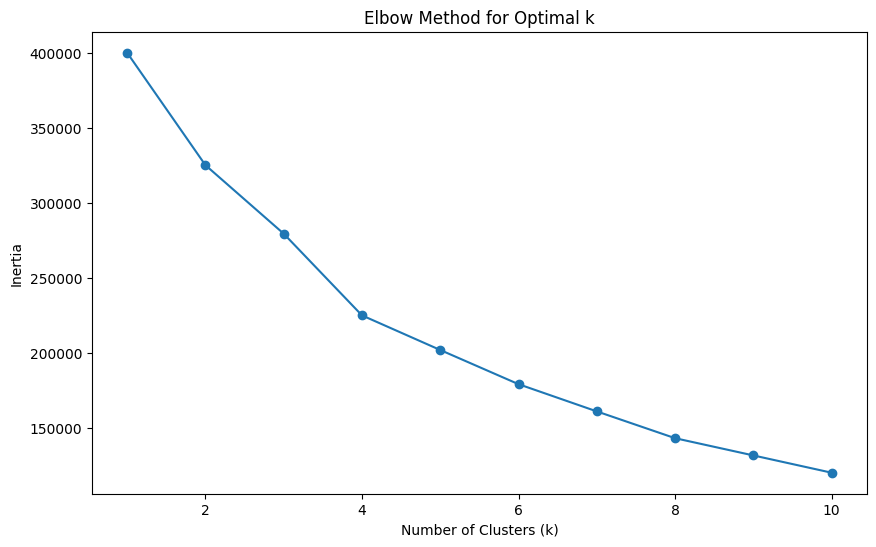

In [3]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Determine the optimal number of clusters using the Elbow method
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_df)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()


The number of optimal cluster is 4 hence our k

In [4]:
# Fit K-means with the chosen number of clusters
k = 6  
kmeans = KMeans(n_clusters=k, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(scaled_df)

# Display the first few rows with the assigned cluster
customer_data.head()


,CustomerID,Age,Gender,Annual_Income,Spending_Score,Location,Loyalty_Status,Preferred_Shopping_Channel,Cluster
0,1,56,Female,103992,36,CityB,1,Online,3
1,2,69,Male,87850,78,CityD,1,Online,3
2,3,46,Male,80873,35,CityB,1,Online,3
3,4,32,Other,31167,79,CityC,0,Online,1
4,5,60,Other,41115,95,CityA,1,In-store,3


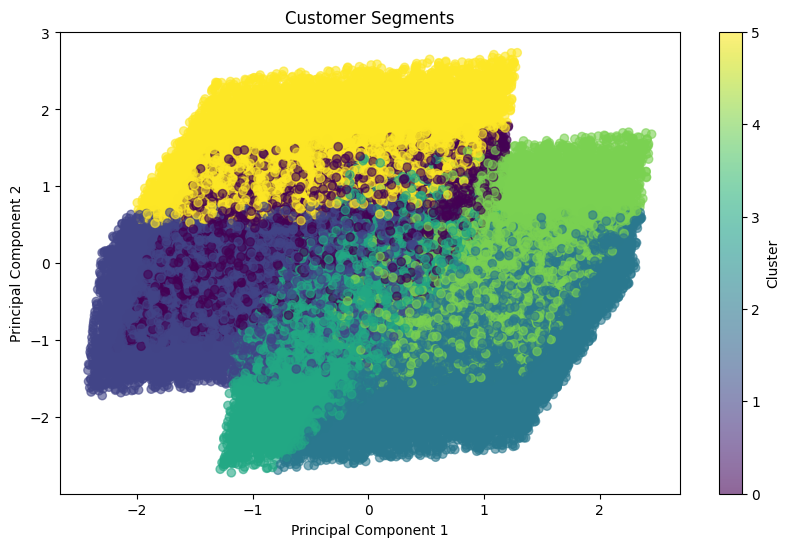

In [5]:
# Plotting clusters using the first two dimensions (using PCA for visualization)
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_df)

plt.figure(figsize=(10, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=customer_data['Cluster'], cmap='viridis', alpha=0.6)
plt.title('Customer Segments')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()


The scatter plot displays distinct clusters of customer segments, characterized by varying densities and shapes. The clusters exhibit a clear separation, indicating diverse customer profiles. Some clusters overlap slightly, suggesting similarities among certain segments, while others are well-defined, highlighting unique behaviors and preferences within the customer base.

In [6]:
# Group by cluster and calculate summary statistics
cluster_summary = customer_data.groupby('Cluster').agg({
    'Age': ['mean', 'median', 'std'],
    'Annual_Income': ['mean', 'median', 'std'],
    'Spending_Score': ['mean', 'median', 'std'],
    'Loyalty_Status': ['mean']
}).reset_index()

print(cluster_summary)


  Cluster        Age                   Annual_Income                         \
                mean median        std          mean   median           std   
0       0  43.424471   44.0  14.964797  43479.788891  42561.0  14404.050258   
1       1  43.890157   44.0  14.943108  69611.707880  69747.0  25943.304184   
2       2  34.910394   35.0  10.257156  42474.613166  41690.0  14075.989789   
3       3  59.287402   60.0   6.355136  71874.868979  72309.0  25975.495370   
4       4  33.294190   33.0   9.424691  96225.408709  97092.0  14685.677346   
5       5  43.341218   43.0  14.991705  96924.929989  97699.0  14218.114918   

  Spending_Score                   Loyalty_Status  
            mean median        std           mean  
0      31.554805   31.0  18.647441            0.0  
1      80.785673   82.0  12.230789            0.0  
2      51.377573   52.0  28.865141            1.0  
3      49.831374   50.0  28.758858            1.0  
4      50.447593   50.0  28.856653            1.0  
5  

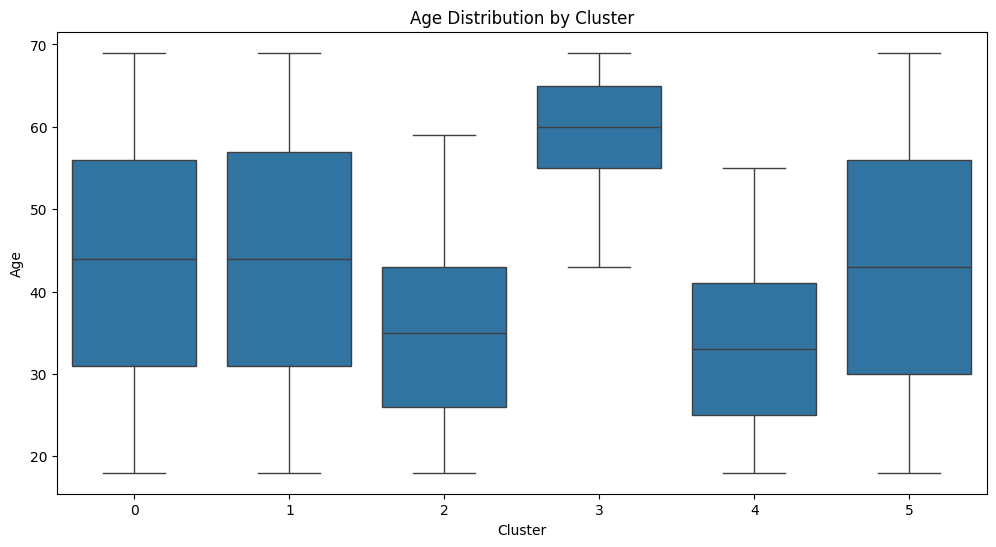

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.boxplot(x='Cluster', y='Age', data=customer_data)
plt.title('Age Distribution by Cluster')
plt.show()

### DBSCAN

In [8]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=5)
customer_data['DBSCAN_Cluster'] = dbscan.fit_predict(scaled_df)


In [9]:
from sklearn.cluster import MiniBatchKMeans

kmeans = MiniBatchKMeans(n_clusters=4, batch_size=1000)  # Adjust parameters as needed
customer_data['KMeans_Cluster'] = kmeans.fit_predict(scaled_df)


### Model Evaluation

In [10]:
from sklearn.metrics import silhouette_score

silhouette_kmeans = silhouette_score(scaled_df, customer_data['Cluster'])

silhouette_dbscan = silhouette_score(scaled_df, customer_data['DBSCAN_Cluster'])

print(f'Silhouette Score K-means: {silhouette_kmeans}')
print(f'Silhouette Score DBSCAN: {silhouette_dbscan}')


Silhouette Score K-means: 0.2364183622583184
Silhouette Score DBSCAN: 0.26355179150416974


#### Silhouette Score for K-means: 0.236

This score suggests that the clustering is relatively poor, but there is some degree of separation between the clusters. It indicates that some samples may be close to the decision boundary, which can affect the overall clustering quality.

#### Silhouette Score for DBSCAN: 0.264

This score is slightly higher than that of K-means, indicating a marginally better clustering performance. This suggests that the clusters formed by DBSCAN are somewhat better separated, with samples being a bit more cohesive within cluste

In [12]:
import pickle

# Save the KMeans model
with open('kmeans_model.pkl', 'wb') as file:
    pickle.dump(kmeans, file)

# Save the scaler as well since it is used to transform new data
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

print("KMeans model and scaler saved as pickle files.")


KMeans model and scaler saved as pickle files.
